In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging
import os


import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, MCMC, NUTS
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from sklearn import preprocessing

pyro.__version__

'1.8.4'

# Rational agent

The idea is to train n models where each model is trained using n trials.

extract valid subjects

In [2]:
import extract_correct_csv
valid_sub = extract_correct_csv.extract_only_valid_subject()

read real data of subject #2 (data equals to all subjects)

In [3]:
# read dataset
df = pd.read_csv('data/newLookAtMe/newLookAtMe02.csv')
df_rational = df[['morphing level', 'shock']]
df_rational['shock'] = df_rational['shock'].astype(int) #setting shock as int instead of boolean
df_rational['morphing level'] = [int(d==6) for d in df_rational['morphing level']] # if morphing level==6 -> 1

/var/folders/hn/nq1_cby521sbf58lnj9qj9mw0000gn/T/ipykernel_48207/522845498.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rational['shock'] = df_rational['shock'].astype(int) #setting shock as int instead of boolean
/var/folders/hn/nq1_cby521sbf58lnj9qj9mw0000gn/T/ipykernel_48207/522845498.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rational['morphing level'] = [int(d==6) for d in df_rational['morphing level']] # if morphing level==6 -> 1


In [4]:
# categorical/multinomial distribution

# uniform prior
prior_counts = torch.ones((2,2))


#model
def model(data):
    prior = pyro.sample("prior", dist.Dirichlet(prior_counts))
    total_counts = int(data.sum())
    pyro.sample("likelihood", dist.Multinomial(total_counts, prior), obs=data)

In [29]:
data_np = df_rational.to_numpy()

HABITUATION_TRIALS = 16
ACQUISITION_TRIALS = 48
data_all = data_np[16:]
learning_data = data_np[HABITUATION_TRIALS:ACQUISITION_TRIALS] # remove only habituation

In [8]:
data = torch.tensor(data_all)
N = data.shape[0]

In [9]:
counter = torch.zeros((N,4))

for i in range(len(data_all)):
    dict_ = {'[0 0]':0, '[0 1]': 0, '[1 0]':0, '[1 1]':0}
    tmp_data = data_all[:i+1]

    # count occurencies
    for x in tmp_data:
        dict_[str(x)] += 1
    values = np.array(list(dict_.values()))
    counter[i] = torch.tensor(values)

In [10]:
# reshape in order to match the Dirichlet distribution
counter = counter.reshape((len(data_all), 2, 2))

In [11]:
nuts_kernel = NUTS(model)
num_samples, warmup_steps = (300, 200)

mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps, disable_progbar=True)
all_means = []

# sampling
for i in range(len(counter)):
    mcmc.run(counter[i])
    hmc_samples = {k: v.detach().cpu().numpy()
                for k, v in mcmc.get_samples().items()}
    means = hmc_samples['prior'].mean(axis=0)
    stds = hmc_samples['prior'].std(axis=0)
    print('observation: ', data_all[i])
    print('probabilities: ', means)
    all_means.append(means)

observation:  [1 1]
probabilities:  [[0.50728464 0.49271536]
 [0.32222754 0.67777234]]
observation:  [0 0]
probabilities:  [[0.69437593 0.3056244 ]
 [0.30818138 0.69181865]]
observation:  [0 0]
probabilities:  [[0.7560236 0.2439767]
 [0.3264225 0.6735771]]
observation:  [1 1]
probabilities:  [[0.74703234 0.25296754]
 [0.2342769  0.76572293]]
observation:  [0 0]
probabilities:  [[0.79460615 0.2053939 ]
 [0.26145706 0.7385429 ]]
observation:  [1 1]
probabilities:  [[0.78022015 0.21977976]
 [0.19561908 0.8043811 ]]
observation:  [1 1]
probabilities:  [[0.7814525  0.21854734]
 [0.15387817 0.8461219 ]]
observation:  [0 0]
probabilities:  [[0.8246217  0.17537814]
 [0.15544811 0.84455204]]
observation:  [1 0]
probabilities:  [[0.842011   0.15798922]
 [0.3000075  0.69999266]]
observation:  [1 1]
probabilities:  [[0.8464716  0.15352835]
 [0.24124445 0.7587553 ]]
observation:  [0 0]
probabilities:  [[0.87105197 0.12894857]
 [0.23794833 0.7620518 ]]
observation:  [0 0]
probabilities:  [[0.8739226

In [13]:
all_means = np.array(all_means)
all_means.shape

(144, 2, 2)

all means -> value of the rational agent

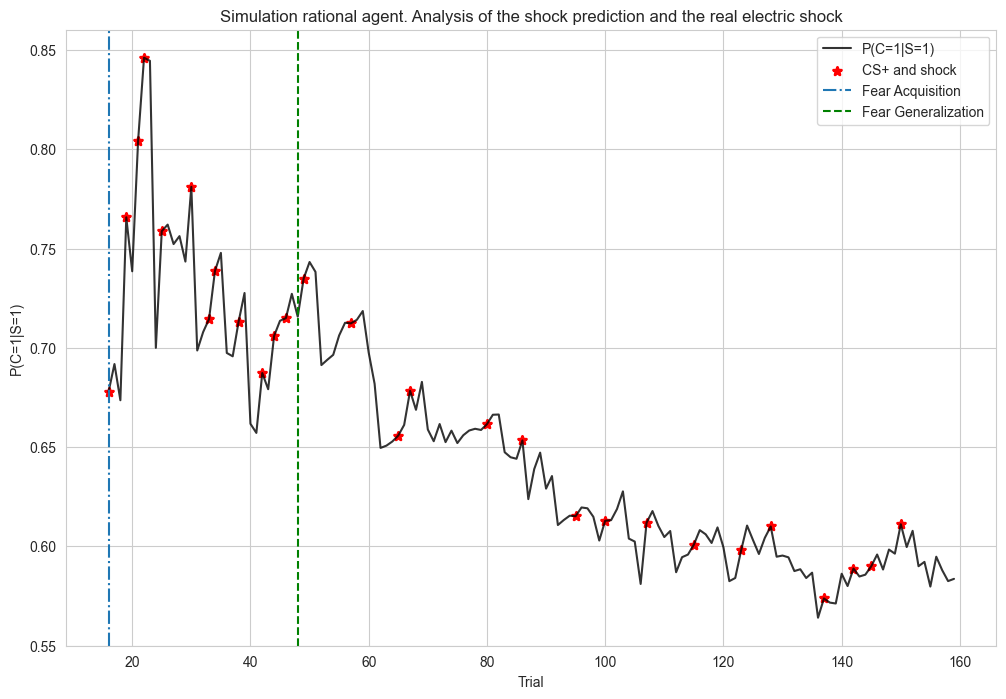

In [30]:
# all 144 trials
X = np.arange(HABITUATION_TRIALS, HABITUATION_TRIALS+len(all_means))
y = all_means[:, 1, 1]

# only simulated training trials
X_training = np.arange(HABITUATION_TRIALS, ACQUISITION_TRIALS)
y_training = all_means[:32, 1, 1]

# points with observation [1 1]
list_ = []
for index, i in enumerate(data_all):
    if np.equal(i, np.array([1,1])).all():
        list_.append(np.array([X[index], y[index]]))
x_points, y_points = np.array(list_)[:,0], np.array(list_)[:,1]

fig = plt.figure(figsize=(12,8))

plt.title('Simulation rational agent. Analysis of the shock prediction and the real electric shock')
plt.plot(X, y, label='P(C=1|S=1)', color = 'black', alpha=0.8)
plt.scatter(x_points, y_points, marker='*', color='red', linewidths=2, label='CS+ and shock')
plt.ylabel('P(C=1|S=1)')
plt.xlabel('Trial')
plt.axvline(x=16, linestyle='-.',label='Fear Acquisition')
plt.axvline(x=48, linestyle='--',color='green',label='Fear Generalization')
plt.legend()
plt.show()

In [31]:
# all trials

total_array_simulated = []

# split between cs+ e non-cs+ visual stimuli
array_csplus_simulated = []
array_csminus_simulated = []

for index, data in enumerate(data_all):
    if data[0] == 1:
        array_csplus_simulated.append([X[index], all_means[index,1,1]])
        total_array_simulated.append(all_means[index,1,1])
    else:
        array_csminus_simulated.append([X[index], all_means[index,0,1]])
        total_array_simulated.append(all_means[index,0,1])

array_csplus_simulated = np.array(array_csplus_simulated)
array_csminus_simulated = np.array(array_csminus_simulated)
total_array_simulated = np.array(total_array_simulated)

In [33]:
# from trial 16 to trial 48
learning_data

array([[1, 1],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0]])

In [34]:
csplus_learning = []
csminus_learning = []
total_simulated_learning = []
for index_train, data_train in enumerate(learning_data):
    if data_train[0] == 1:
        csplus_learning.append([X_training[index_train], all_means[index_train,1,1]])
        total_simulated_learning.append(all_means[index_train,1,1])
    else:
        csminus_learning.append([X_training[index_train], all_means[index_train,0,1]])
        total_simulated_learning.append(all_means[index_train,0,1])

total_simulated_learning = np.array(total_simulated_learning)
csplus_learning = np.array(csplus_learning)
csminus_learning = np.array(csminus_learning)

In [318]:
df_ = df[['shock', 'rating', 'morphing level']]
df_['shock'] = df_['shock'].astype(int)
df_['morphing level'] = [int(d == 6) for d in df_['morphing level']]
df_['rating'] = df_['rating'].replace([1, 2, 3, 4, 5], [0.2, 0.4, 0.6, 0.8, 1])

/tmp/ipykernel_129587/4112460405.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['shock'] = df_['shock'].astype(int)
/tmp/ipykernel_129587/4112460405.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['morphing level'] = [int(d == 6) for d in df_['morphing level']]
/tmp/ipykernel_129587/4112460405.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

In [319]:
df_

,shock,rating,morphing level
0,0,0.6,0
1,0,0.6,1
2,0,0.6,1
3,0,0.6,0
4,0,0.6,0
...,...,...,...
155,0,0.2,0
156,0,0.2,0
157,0,0.2,0
158,0,0.2,0


In [321]:
#remove first 16 trials real data
df_new=df_
#consider only the learning phase
df_learning = df_
df_learning

,shock,rating,morphing level
0,0,0.6,0
1,0,0.6,1
2,0,0.6,1
3,0,0.6,0
4,0,0.6,0
...,...,...,...
155,0,0.2,0
156,0,0.2,0
157,0,0.2,0
158,0,0.2,0


In [322]:
y_plus_real = df_new.loc[df_new['morphing level']==1].rating.values
x_plus_real = np.array(df_new.loc[df_new['morphing level']==1].index)
y_minus_real = df_new.loc[df_new['morphing level']==0].rating.values
x_minus_real = np.array(df_new.loc[df_new['morphing level']==0].index)
y_real=df_new.rating.values

y_plus_train = df_learning.loc[df_learning['morphing level']==1].rating.values
x_plus_train = np.array(df_learning.loc[df_learning['morphing level']==1].index)
y_minus_train = df_learning.loc[df_learning['morphing level']==0].rating.values
x_minus_train = np.array(df_learning.loc[df_learning['morphing level']==0].index)
y_train=df_learning.rating.values

TypeError: list indices must be integers or slices, not tuple

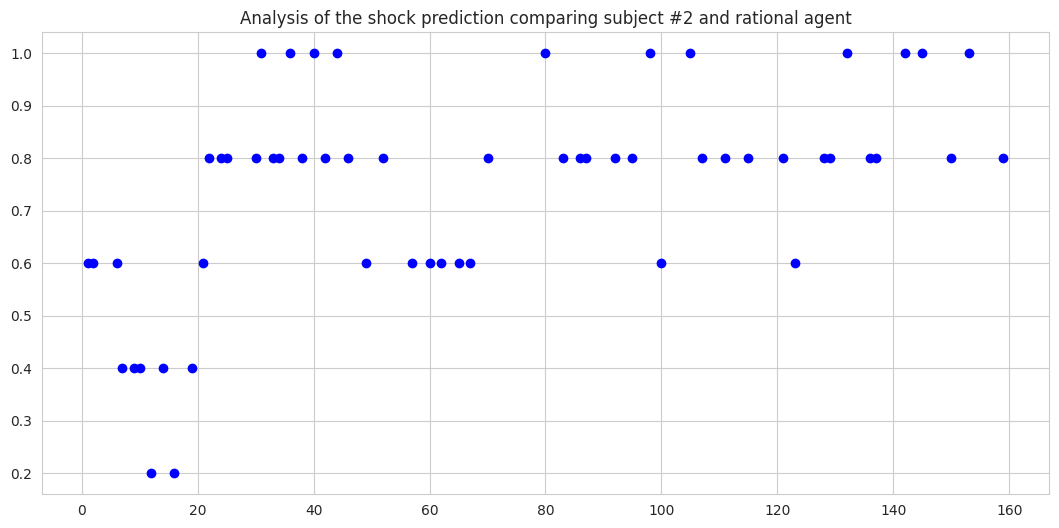

In [323]:
fig = plt.figure(figsize=(13,6))
plt.title('Analysis of the shock prediction comparing subject #2 and rational agent')
plt.scatter(x_plus_real, y_plus_real, color='blue', label='cs+ real')
plt.scatter(array_csplus_simulated[:,0], array_csplus_simulated[:,1], color='darkblue', label='cs+ simulated')
plt.scatter(x_minus_real, y_minus_real, color='red', label='cs- real')
plt.scatter(array_csminus_simulated[:,0], array_csminus_simulated[:,1], color='darkred', label='cs- simulated')
plt.legend(loc='right')
plt.axvline(x=16, linestyle='--', color='green')
plt.axvline(x=48, linestyle='--', color='green')
plt.xlabel('Trial')
plt.ylabel('P(condition | visual stimulus)')
plt.show()

In [18]:
print(len(y_minus_train), len(csminus_learning[:,1]))

16 16


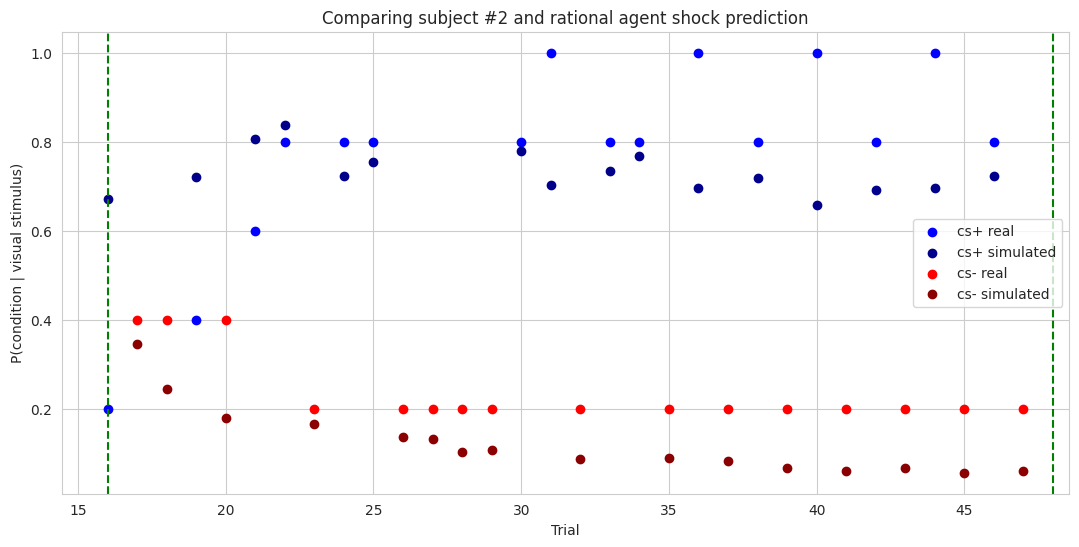

In [25]:
fig2 = plt.figure(figsize=(13,6))
plt.title('Comparing subject #2 and rational agent shock prediction')
plt.scatter(x_plus_train, y_plus_train, color='blue', label='cs+ real')
plt.scatter(csplus_learning[:,0], csplus_learning[:,1], color='darkblue', label='cs+ simulated')
plt.scatter(x_minus_train, y_minus_train, color='red', label='cs- real')
plt.scatter(csminus_learning[:,0], csminus_learning[:,1], color='darkred', label='cs- simulated')
plt.legend(loc='right')
plt.axvline(x=16, linestyle='--', color='green')
plt.axvline(x=48, linestyle='--', color='green')
plt.xlabel('Trial')
plt.ylabel('P(condition | visual stimulus)')
plt.show()
plt.show()

## analysis of the correlation between rational agent and real subject

In [ ]:
np.corrcoef(y_train,total_simulated_learning)

In [ ]:
# rating between 16-48 trial rational agent
rating_rational = total_simulated_learning

In [103]:
df_correlation = pd.DataFrame(columns=['subject','pearson'])

for sub in valid_sub:
    subj_ = extract_correct_csv.read_correct_subject_csv(sub)
    df_sub = pd.read_csv('data/newLookAtMe/newLookAtMe'+subj_+'.csv')
    df_sub = df_sub[['shock', 'rating', 'morphing level']]
    df_sub['shock'] = df_sub['shock'].astype(int)
    df_sub['morphing level'] = [int(d == 6) for d in df_sub['morphing level']]
    df_sub['rating'] = df_sub['rating'].replace([1, 2, 3, 4, 5], [0.2, 0.4, 0.6, 0.8, 1])
    df_sub_learn = df_sub[16:48]
    rating_sub = np.array(df_sub_learn['rating'])

    pearson = round(np.corrcoef(rating_sub,rating_rational)[0][1],2)
    df_correlation = df_correlation.append({'subject':sub,'pearson':pearson},ignore_index=True)

/tmp/ipykernel_129587/3991449076.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_correlation = df_correlation.append({'subject':sub,'pearson':pearson},ignore_index=True)
/tmp/ipykernel_129587/3991449076.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_correlation = df_correlation.append({'subject':sub,'pearson':pearson},ignore_index=True)
/tmp/ipykernel_129587/3991449076.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_correlation = df_correlation.append({'subject':sub,'pearson':pearson},ignore_index=True)
/tmp/ipykernel_129587/3991449076.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_correlation = df_corr

In [102]:
type(df_correlation['subject'][0])
df

numpy.float64

In [115]:
sias_df = pd.read_csv('data/sias_score.csv').drop(columns='social_anxiety')
sias_df['subject'] = [float(x) for x in sias_df['subject']]

lds_df = pd.read_csv('data/lds_subjects.csv')
lds_df['subject'] = [float(x) for x in lds_df['subject']]

,subject,sias_score
0,1.0,21.0
1,2.0,11.0
2,3.0,30.0
3,4.0,12.0
4,5.0,30.0
5,6.0,8.0
6,7.0,25.0
7,8.0,6.0
8,9.0,NaN
9,10.0,10.0


In [116]:
df_corr = df_correlation.join(lds_df, lsuffix='', rsuffix='_other',how='inner').drop(columns='subject_other')
df_corr_ = df_corr.join(sias_df,lsuffix='', rsuffix='_other',how='inner').drop(columns='subject_other')
df_corr_

,subject,pearson,lds,sias_score
0,1.0,0.58,0.201,21.0
1,2.0,0.87,0.828,11.0
2,4.0,NaN,0.504,30.0
3,5.0,0.74,0.111,12.0
4,6.0,NaN,0.953,30.0
5,7.0,0.94,1.312,8.0
6,13.0,NaN,0.535,25.0
7,15.0,0.84,0.583,6.0
8,16.0,0.36,0.682,NaN
9,17.0,0.32,-0.323,10.0


In [271]:
df_corr_notna = df_corr_[df_corr_['pearson'].notna()]
df_corr_notna = df_corr_notna[df_corr_['lds'].notna()]
df_corr_notna = df_corr_notna[df_corr_['sias_score'].notna()]

/tmp/ipykernel_129587/3592619868.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_corr_notna = df_corr_notna[df_corr_['lds'].notna()]
/tmp/ipykernel_129587/3592619868.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_corr_notna = df_corr_notna[df_corr_['sias_score'].notna()]


In [278]:
df_corr_notna['sias_score'] = [round(x,2) for x in preprocessing.normalize([df_corr_notna['sias_score']])[0]]
df_corr_notna['lds'] = [round(x,2) for x in preprocessing.normalize([df_corr_notna['lds']])[0]]
df_corr_notna['pearson'] = [round(x,2) for x in preprocessing.normalize([df_corr_notna['pearson']])[0]]


In [279]:
df_corr_notna

,subject,pearson,lds,sias_score
0,1.0,0.19,0.05,0.31
1,2.0,0.29,0.22,0.16
3,5.0,0.24,0.03,0.18
5,7.0,0.31,0.34,0.12
7,15.0,0.28,0.15,0.09
9,17.0,0.11,-0.08,0.15
10,21.0,0.01,0.06,0.16
11,22.0,0.19,0.04,0.28
13,26.0,0.28,0.18,0.28
14,27.0,0.26,0.16,0.23


In [280]:
np.corrcoef(df_corr_notna['pearson'],df_corr_notna['lds'])

array([[1.        , 0.43168667],
       [0.43168667, 1.        ]])

In [281]:
np.corrcoef(df_corr_notna['pearson'],df_corr_notna['sias_score'])

array([[ 1.       , -0.0378465],
       [-0.0378465,  1.       ]])

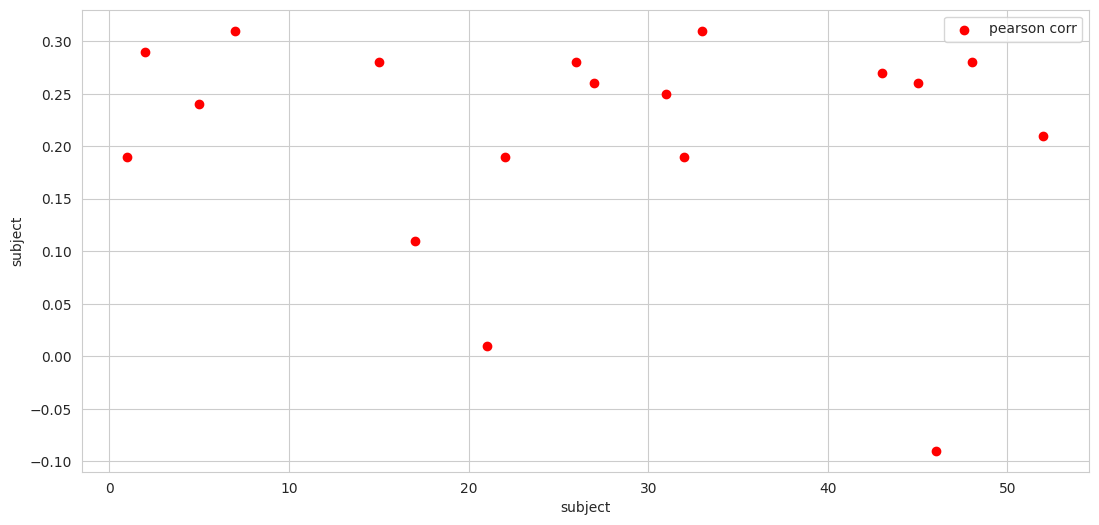

In [292]:
fig3 = plt.figure(figsize=(13,6))
x = (df_corr_notna['subject'])
pear = df_corr_notna['pearson']
lds = df_corr_notna['lds']
sias = df_corr_notna['sias_score']
plt.scatter(x,pear,color='red',label='pearson corr')
#plt.scatter(x,lds,color='blue',label='lds')
#plt.scatter(x,sias, color='green',label='social anx')
plt.xlabel('subject')
plt.ylabel('subject')

plt.legend()

In [286]:
df_corr_notna['subject'] = [int(x) for x in df_corr_notna['subject']]

In [287]:
subjects = tuple(df_corr_notna['subject'])

In [288]:
values = {'pearson':(),'lds':(),'sias':()}
for index,row in df_corr_notna.iterrows():
    new_p = values['pearson'] + (row['pearson'],)
    values.update({'pearson':new_p})
    new_l = values['lds'] + (row['lds'],)
    values.update({'lds':new_l})
    new_s = values['sias'] + (row['sias_score'],)
    values.update({'sias':new_s})

In [293]:
values_no_sias = {'pearson':(),'lds':()}
for index,row in df_corr_notna.iterrows():
    new_p = values_no_sias['pearson'] + (row['pearson'],)
    values_no_sias.update({'pearson':new_p})
    new_l = values_no_sias['lds'] + (row['lds'],)
    values_no_sias.update({'lds':new_l})

In [300]:
subjects = tuple(df_corr_notna['subject'])
values_no_lds = {'pearson': (), 'sias': ()}
for index, row in df_corr_notna.iterrows():
    new_p = values_no_lds['pearson'] + (row['pearson'],)
    values_no_lds.update({'pearson': new_p})
    new_s = values_no_lds['sias'] + (row['sias_score'],)
    values_no_lds.update({'sias': new_s})

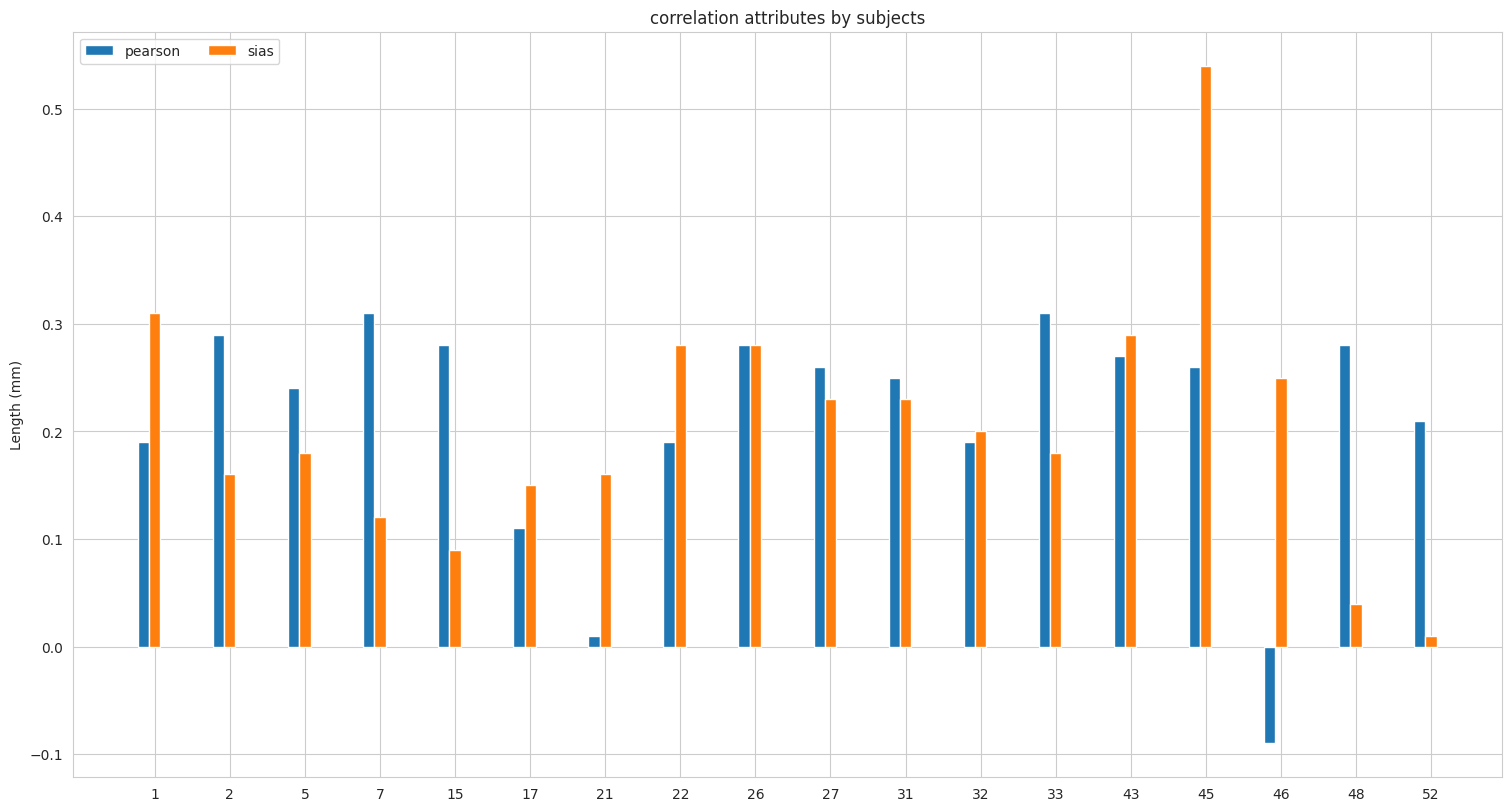

In [304]:
x = np.arange(len(subjects))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(15,8),constrained_layout=True)

for attribute, measurement in values_no_lds.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('correlation attributes by subjects')
ax.set_xticks(x + width, subjects)
ax.legend(loc='upper left', ncols=3)

plt.show()

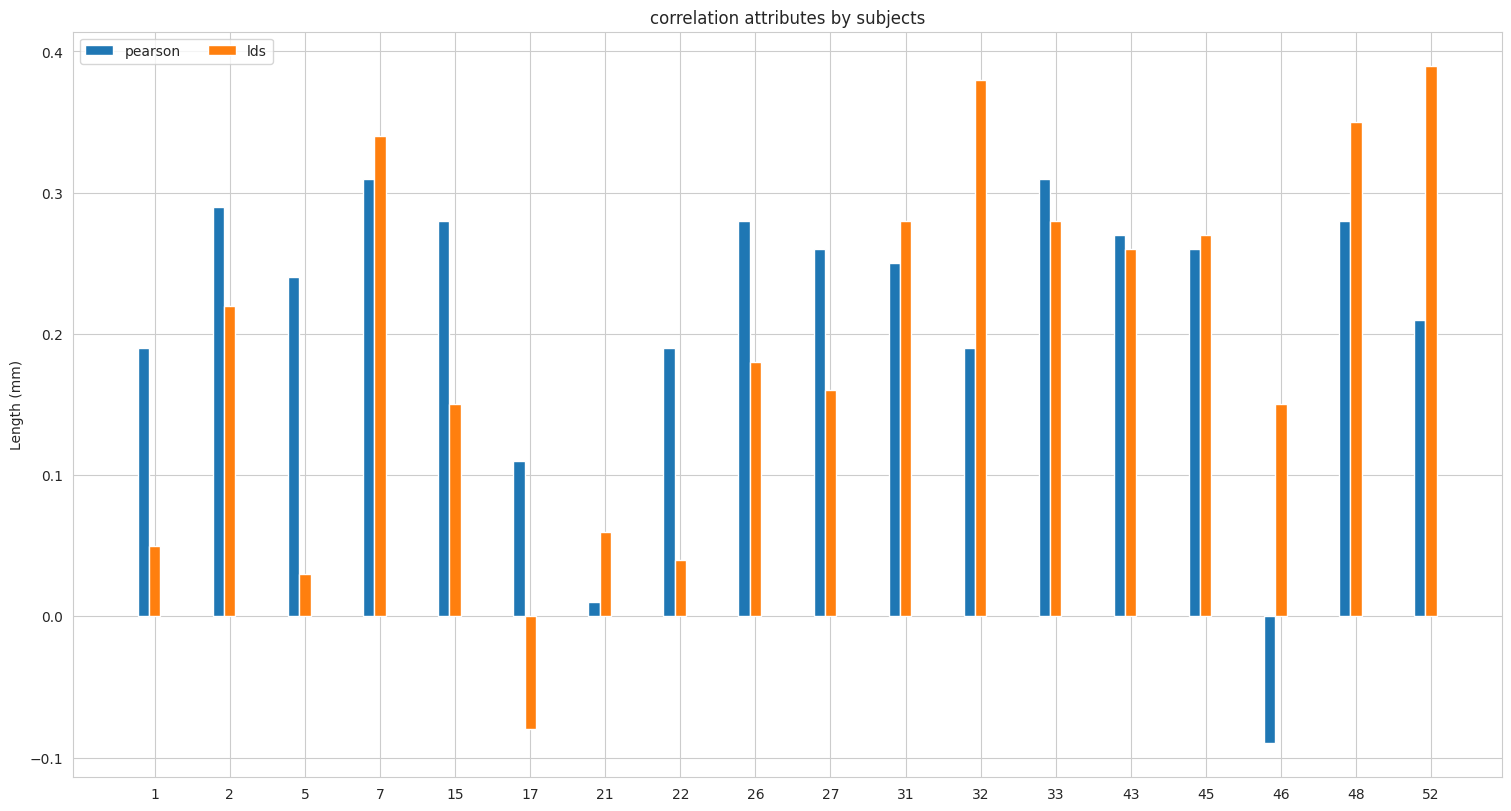

In [303]:
x = np.arange(len(subjects))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(15,8),constrained_layout=True)

for attribute, measurement in values_no_sias.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('correlation attributes by subjects')
ax.set_xticks(x + width, subjects)
ax.legend(loc='upper left', ncols=3)

plt.show()

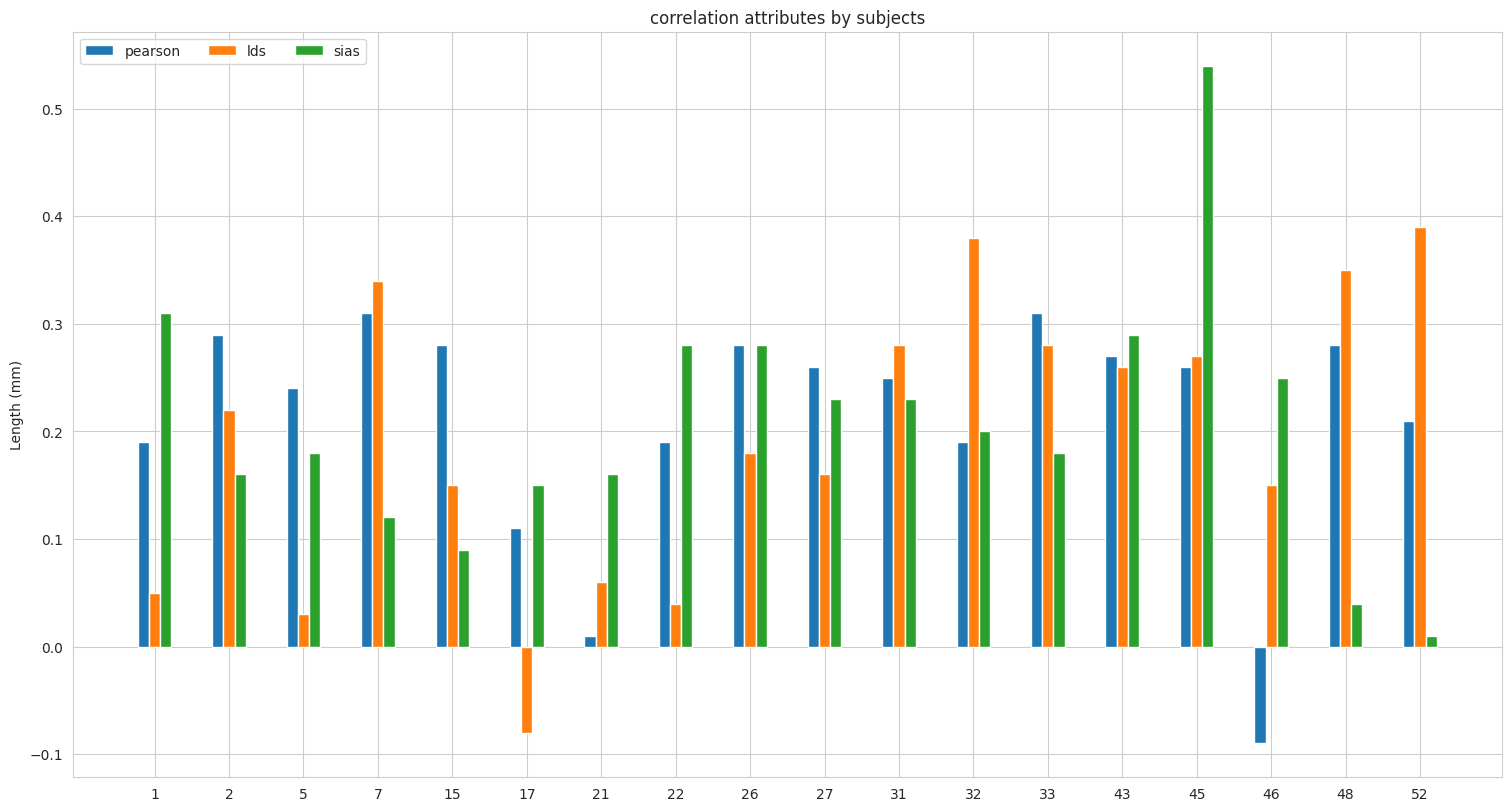

In [305]:
x = np.arange(len(subjects))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(15,8),constrained_layout=True)

for attribute, measurement in values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('correlation attributes by subjects')
ax.set_xticks(x + width, subjects)
ax.legend(loc='upper left', ncols=3)

plt.show()

# rational agent sliding window

The idea is to have a rational agent with a limited memory over previous trials.
k = param sliding window dimension


In [306]:
import extract_correct_csv
valid_sub = extract_correct_csv.extract_only_valid_subject()

In [307]:
# read dataset
df = pd.read_csv('data/newLookAtMe/newLookAtMe02.csv')
df_rational = df[['morphing level', 'shock']]
df_rational['shock'] = df_rational['shock'].astype(int) #setting shock as int instead of boolean
df_rational['morphing level'] = [int(d==6) for d in df_rational['morphing level']] # if morphing level==6 -> 1

/tmp/ipykernel_129587/522845498.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rational['shock'] = df_rational['shock'].astype(int) #setting shock as int instead of boolean
/tmp/ipykernel_129587/522845498.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rational['morphing level'] = [int(d==6) for d in df_rational['morphing level']] # if morphing level==6 -> 1


In [308]:
# categorical/multinomial distribution

# uniform prior
prior_counts = torch.ones((2,2))


#model
def model(data):
    prior = pyro.sample("prior", dist.Dirichlet(prior_counts))
    total_counts = int(data.sum())
    pyro.sample("likelihood", dist.Multinomial(total_counts, prior), obs=data)

## Deep Markov model

![example](https://pyro.ai/examples/_static/img/model.png)

In [1]:
import argparse
import logging
import time
from os.path import exists
import numpy as np
import torch
import torch.nn as nn
import pyro
import pyro.contrib.examples.polyphonic_data_loader as poly
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions import TransformedDistribution
from pyro.distributions.transforms import affine_autoregressive
from pyro.infer import (
    SVI,
    JitTrace_ELBO,
    Trace_ELBO,
    TraceEnum_ELBO,
    TraceTMC_ELBO,
    config_enumerate,
)
from pyro.optim import ClippedAdam

In [3]:
# emission function (Emit in the figure)
class Emitter(nn.Module):
    """
    Parameterizes the bernoulli observation likelihood p(x_t|z_t)

    """
    def __init__(self, input_dim, z_dim, emission_dim):
        super().__init__()
        # emission_dim is the number of hidden units in the neural network
        # three linear transformations used in the neural network
        self.lin_z_to_hidden = nn.Linear(z_dim, emission_dim)
        self.lin_hidden_to_hidden = nn.Linear(emission_dim, emission_dim)
        self.lin_hidden_to_input = nn.Linear(emission_dim, input_dim)
        # two non linear used in the neural network
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z_t):
        """
        Given the latent z at a particular time step t, we return the vector of probabilities 'ps' that parametrizes the bernoulli distribution p(x_t|z_t)
        Taken together the elements of ps encode which notes we expect to observe at time t given the state of the system (as encoded in z_t).
        """
        h1 = self.relu(self.lin_z_to_hidden(z_t))
        h2 = self.relu(self.lin_hidden_to_hidden(h1))
        ps = self.sigmoid(self.lin_hidden_to_input(h2))
        return ps

In [4]:
# gated transition (Trans in the figure above)
class GatedTransition(nn.Module):
    """
    Parameterizes the gaussian latent transition probability p(z_t | z_{t-1})
    """
    def __init__(self, z_dim, transition_dim):
        super().__init__()
        # six linear transform
        self.lin_gate_z_to_hidden = nn.Linear(z_dim, transition_dim)
        self.lin_gate_hidden_to_z = nn.Linear(transition_dim, z_dim)
        self.lin_proposed_mean_z_to_hidden = nn.Linear(z_dim, transition_dim)
        self.lin_proposed_mean_hidden_to_z = nn.Linear(transition_dim, z_dim)
        self.lin_sig = nn.Linear(z_dim, z_dim)
        self.lin_z_to_loc = nn.Linear(z_dim, z_dim)

        # modify the default initialization of lin_z_to_loc
        # so that it's starts out as the IDENTITY FUNCTION
        self.lin_z_to_loc.weight.data = torch.eye(z_dim)
        self.lin_z_to_loc.bias.data = torch.zeros(z_dim)

        # three non linear
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softplus = nn.Softplus()


    def forward(self, z_t_1):
        """
        Given the latent z_{t-1} corresponding to the time step t-1 we return the mean and scale vectors that parameterize the
        (diagonal) gaussian distribution p(z_t | z_{t-1})
        """
        # compute the gating function
        _gate = self.relu(self.lin_gate_z_to_hidden(z_t_1))
        gate = self.sigmoid(self.lin_gate_hidden_to_z(_gate))

        # compute the 'proposed mean'
        _proposed_mean = self.relu(self.lin_proposed_mean_z_to_hidden(z_t_1))
        proposed_mean = self.lin_proposed_mean_hidden_to_z(_proposed_mean)

        # assemble the actual mean used to sample z_t, which mixes a linear transformation of z_{t-1} with the proposed mean
        # modulated by the gating function
        loc = (1 - gate) * self.lin_z_to_loc(z_t_1) + gate * proposed_mean

        # compute the scale used to sample z_t, using the proposed
        # mean from above as input. the softplus ensures that scale is positive
        scale = self.softplus(self.lin_sig(self.relu(proposed_mean)))

        # return loc, scale which can be fed into Normal (mean and covariance of our Gaussian)
        return loc, scale

In [ ]:
# simple model (not working)
def model(...):
    # initializer
    z_prev = self.z_0

    # sample the latents z and observed x's one time step at a time
    for t in range(1, T_max + 1):
        # the next two lines of code sample z_t ~ p(z_t | z_{t-1}).
        # first compute the parameters of the diagonal gaussian
        # distribution p(z_t | z_{t-1})
        z_loc, z_scale = self.trans(z_prev)
        # then sample z_t according to dist.Normal(z_loc, z_scale)
        z_t = pyro.sample("z_%d" % t, dist.Normal(z_loc, z_scale))

        # compute the probabilities that parameterize the bernoulli likelihood
        emission_probs_t = self.emitter(z_t)
        # the next statement instructs pyro to observe x_t according to the
        # bernoulli distribution p(x_t|z_t)
        pyro.sample("obs_x_%d" % t,
                    dist.Bernoulli(emission_probs_t),
                    obs=mini_batch[:, t - 1, :])
        # the latent sampled at this time step will be conditioned upon
        # in the next time step so keep track of it
        z_prev = z_t

### Agent example

To define a hidden Markov Model (HMM) for this scenario, we need to identify the key components of an HMM:
1.	States: In our case, the state is whether the agent is in a shocked state or not. We will use 0 to represent a non-shocked state and 1 to represent a shocked state.
2.	Observations: The observation is whether the agent sees an aggressive or non-aggressive image. We will use 0 to represent a non-aggressive image and 1 to represent an aggressive image.
3.	Transition probabilities: The transition probabilities determine the probability of moving from one state to another. In our case, the transition probabilities will depend on the current state and the shock received. Specifically, if the agent is in a non-shocked state and receives a shock, there is a high probability of transitioning to the shocked state. Conversely, if the agent is in the shocked state and does not receive a shock, there is a high probability of transitioning to the non-shocked state.
4.	Emission probabilities: The emission probabilities determine the probability of observing a particular image given the current state. In our case, the emission probabilities will depend on the current state. Specifically, if the agent is in the non-shocked state, there is a high probability of observing a non-aggressive image, and if the agent is in the shocked state, there is a high probability of observing an aggressive image.

In [12]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import Trace_ELBO, SVI


def transition_model(state):
    p_stay = 0.7 if state else 0.9
    p_switch = 1 - p_stay
    return pyro.sample('state_transition', dist.Categorical(torch.tensor([p_stay, p_switch])))


def emission_model(state):
    p_emission = 0.9 if state else 0.1
    return pyro.sample('emission', dist.Bernoulli(torch.tensor(p_emission)))


def initial_model():
    return pyro.sample('initial_state', dist.Categorical(torch.tensor([0.5, 0.5])))


def model(stimuli, shock, initial_state):
    states = [pyro.sample('init_state', dist.Categorical(initial_state))]
    emissions = [emission_model(states[0]).item()]
    for i in range(1, len(stimuli)):
        states.append(transition_model(states[i-1]).item())
        emissions.append(emission_model(states[i]).item())
    return states, emissions


def guide(stimuli, shock, initial_state, states, emissions):
    for i in range(len(stimuli)):
        states[i] = pyro.sample('state_{}'.format(i), dist.Bernoulli(torch.tensor(0.5)))
        emissions[i] = pyro.sample('emission_{}'.format(i), dist.Bernoulli(torch.tensor(0.5)))


stimuli = torch.tensor([0, 0, 0, 1, 1, 0, 1, 1, 0])
shock = torch.tensor([0, 0, 0, 1, 1, 0, 0, 1, 0])
initial_state = torch.tensor([0.5, 0.5])

optimizer = pyro.optim.Adam({'lr': 0.1})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

for i in range(1000):
    states, emissions = model(stimuli, shock, initial_state)
    loss = svi.step(stimuli, shock, initial_state, states, emissions)
    if i % 100 == 0:
        print("step {}: loss = {}".format(i, loss))


TypeError: model() takes 3 positional arguments but 5 were given